Now that I know which models to use since they work best with market datasets, I will try to get better results by reducing the number of features by performing a Principal Component Analysis.

In [155]:
# install required python packages
!pip install -r requirements.txt

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [156]:
import os
import requests
from datetime import datetime, timedelta
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [157]:
def get_last_close_timestamp():
    # If today is a weekend day, return today's timestamp
    current_time = datetime.today()
    weekno = current_time.weekday()
    if weekno >= 5:
        return int(current_time.timestamp())

    # If market is currently opened, return yesterday's post-close timestamp
    today_market_close = current_time.replace(hour=18, minute=0, second=0, microsecond=0)
    if now < today_market_close:
        yesterday_market_close = (current_time - timedelta(days=1)).replace(hour=18, minute=0, second=0, microsecond=0)
        return int(yesterday_market_close.timestamp())

    # Otherwise return today's post-close timestamp
    return int(today_market_close.timestamp())

def download_stock_data(symbol, start=None, end=None):
    filepath = os.path.join(os.getcwd(), 'historical-data_{}.csv'.format(symbol))
    if not start:
        start = 636278400 # oldest CAC40 quotation date - March 1st 1990 8am
    if not end:
        end = get_last_close_timestamp()
    url = 'http://query1.finance.yahoo.com/v7/finance/download/{}?period1={:d}&period2={:d}&interval=1d&events=history'.format(symbol, int(start), int(end))
    response = requests.get(url)
    with open(filepath, 'wb') as f:
        f.write(response.content)
    try:
        return pd.read_csv(filepath, index_col=0, parse_dates=True, infer_datetime_format=True)
    except:
        print('Error fetching URL {}:'.format(url))
        print(response.content)
        raise

# Retrieve and preprocess market data for a given stock
def get_stock_dataset(symbol, num_days_to_predict=7):
    # Download stock historical data in a DataFrame
    df = download_stock_data(symbol)

    # Add technical analysis indicators as features
    df = ta.add_all_ta_features(df, open='Open', high='High', low='Low', close='Close', volume='Volume')

    # Add historical data for major indices as features
    start_timestamp = datetime.timestamp(df.index[0])
    end_timestamp = datetime.timestamp(df.index[-1])
    cac40_df = download_stock_data('^FCHI', start_timestamp, end_timestamp)
    sbf120_df = download_stock_data('^SBF120', start_timestamp, end_timestamp)
    # Drop 'Volume' and 'Adj Close' features, meaningless regarding market indices
    drop_index_cols = ['Volume', 'Adj Close']
    cac40_df.drop(drop_index_cols, axis=1, inplace=True)
    sbf120_df.drop(drop_index_cols, axis=1, inplace=True)
    # Prefix columns with index name
    prefixed_cac_cols = []
    prefixed_sbf_cols = []
    for cac_col, sbf_col in zip(cac40_df.columns, sbf120_df.columns):
        prefixed_cac_cols.append('cac40_' + cac_col)
        prefixed_sbf_cols.append('sbf120_' + sbf_col)
    cac40_df.columns = prefixed_cac_cols
    sbf120_df.columns = prefixed_sbf_cols
    # Add them to the main dataset
    df = pd.concat([df, cac40_df], axis=1)
    df = pd.concat([df, sbf120_df], axis=1)

    # Fill NaNs with neutral values
    df.interpolate(axis=0, limit_direction='both', inplace=True)

    # Build target variable dataset
    adjclose_df = pd.DataFrame()
    adjclose_cols = []
    for i in range(1, num_days_to_predict + 1):
        colname = 'AdjClose_D+' + str(i)
        adjclose_df[colname] = df['Adj Close'].shift(periods=-i)
        adjclose_cols.append(colname)
    adjclose_df.columns = adjclose_cols
    # Drop rows with shifted NaN values
    adjclose_df.drop(adjclose_df.tail(i).index,inplace=True)
    df.drop(df.tail(i).index,inplace=True)

    return df, adjclose_df

In [158]:
num_days_to_predict = 3
X_df, y_df = get_stock_dataset('AI.PA', num_days_to_predict)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [159]:
X_df.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-24,128.149994,128.300003,126.199997,126.199997,126.199997,861152.0,2.243262e+08,248351212.0,0.147496,300993.854921,...,-2.233202,259.935897,4985.629883,5004.040039,4871.359863,4871.359863,3648.330078,3648.330078,3648.330078,3648.330078
2020-06-25,126.199997,127.500000,124.449997,126.849998,126.849998,1043681.0,2.249250e+08,249394893.0,0.120353,354908.117601,...,0.513734,261.789769,4860.160156,4941.959961,4795.049805,4918.580078,3648.330078,3648.330078,3648.330078,3648.330078
2020-06-26,128.000000,128.850006,126.000000,126.099998,126.099998,815432.0,2.241668e+08,248579461.0,0.042552,216839.243658,...,-0.593004,259.650689,4965.720215,5014.830078,4908.149902,4909.640137,3648.330078,3648.330078,3648.330078,3648.330078
2020-06-29,126.099998,127.750000,125.699997,127.500000,127.500000,966640.0,2.248977e+08,249546101.0,0.081401,379190.485033,...,1.104114,263.643644,4887.229980,4977.629883,4867.330078,4945.459961,3648.330078,3648.330078,3648.330078,3648.330078
2020-06-30,127.500000,128.399994,126.599998,128.399994,128.399994,1021045.0,2.259187e+08,250567146.0,0.092838,456296.754847,...,0.703398,266.210523,4958.939941,4967.350098,4901.959961,4935.990234,3648.330078,3648.330078,3648.330078,3648.330078


In [160]:
y_df.tail()

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3
Date,,,
2020-06-24,126.849998,126.099998,127.500000
2020-06-25,126.099998,127.500000,128.399994
2020-06-26,127.500000,128.399994,128.449997
2020-06-29,128.399994,128.449997,132.649994
2020-06-30,128.449997,132.649994,130.350006


In [161]:
# Normalize dataset
X_scaler = MinMaxScaler().fit(X_df.values)
y_scaler = MinMaxScaler().fit(y_df.values)

X_scaled = X_scaler.transform(X_df.values)
y_scaled = y_scaler.transform(y_df.values)

Now that the dataset is ready and preprocessed, I will try to apply Principal Component Analysis to reduce the number of features, now equal to 86

In [162]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Let's investigate the variance accounted for by each principal component:

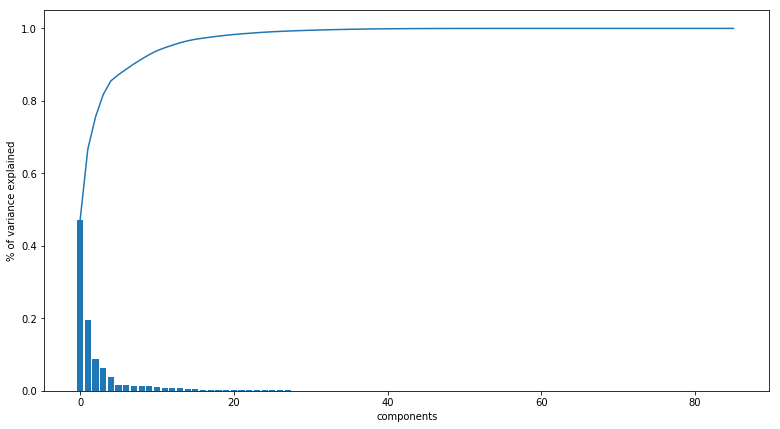

In [163]:
components_indices = np.arange(len(pca.explained_variance_ratio_))

plt.figure(figsize=(13, 7))

# variance explained per component
plt.bar(components_indices, pca.explained_variance_ratio_)

# cumulative variance explained
cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(components_indices, cumulative_sum)
plt.xlabel('components')
plt.ylabel('% of variance explained')
plt.show()

Let's apply PCA again while selecting for number of components to keep to explain 90% variance. I chose 90% arbitrarily, keeping in mind that choosing a greater threshold could make the future model not generalize very well.

In [164]:
print(cumulative_sum)

[0.47117752 0.66661169 0.75534162 0.81717722 0.85512366 0.87247397
 0.88750142 0.90195018 0.9151917  0.92774891 0.93840149 0.94648891
 0.95365499 0.96037822 0.96581753 0.97003157 0.97309626 0.97601817
 0.97867397 0.98105384 0.98313433 0.98497329 0.98656149 0.98808065
 0.98953702 0.99068385 0.99172212 0.9926584  0.99347796 0.99425146
 0.99491621 0.9955341  0.99608423 0.99659367 0.99705553 0.99747251
 0.99785436 0.99817288 0.99844341 0.9986877  0.99891501 0.99911042
 0.99927703 0.99942827 0.99953754 0.99961966 0.99969124 0.99975945
 0.99981083 0.9998411  0.9998664  0.99988776 0.99990714 0.99992269
 0.99993468 0.99994562 0.99995555 0.99996486 0.99997215 0.99997828
 0.99998405 0.99998821 0.99999105 0.99999324 0.99999487 0.99999645
 0.99999749 0.99999824 0.99999881 0.9999993  0.99999971 0.99999979
 0.99999986 0.99999993 0.99999996 0.99999998 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [165]:
for idx, comp in enumerate(cumulative_sum):
    if comp * 100 >= 90:
        break
components_nb = idx + 1
print('{} components are required to explain 90% variance'.format(components_nb))

8 components are required to explain 90% variance


Let's now dig deeper, by investigating the feature weight of each original feature for each of the 8 principal components: 

In [166]:
comp_feat_weights = pd.DataFrame(pca.components_, columns=X_df.columns, index=np.arange(len(pca.components_)))
pd.set_option('display.max_rows', comp_feat_weights.shape[1])

# Print feature weights sorted for the first 8 principal components
for i in range(8):
    print('Feature weights for principal component {}'.format(i + 1))
    print(comp_feat_weights.iloc[i].sort_values(ascending=False))
    print('')

Feature weights for principal component 1
trend_ichimoku_b             0.197137
trend_sma_slow               0.193192
trend_ema_slow               0.193026
trend_ichimoku_base          0.192956
trend_visual_ichimoku_b      0.192955
volatility_bbl               0.192250
Adj Close                    0.190691
volatility_bbm               0.190588
trend_ichimoku_a             0.189893
volume_vwap                  0.187665
trend_ema_fast               0.187063
trend_sma_fast               0.186477
trend_ichimoku_conv          0.186233
volatility_kch               0.186186
trend_psar_down              0.185887
volatility_kcc               0.185689
volatility_kcl               0.184682
trend_visual_ichimoku_a      0.184457
High                         0.183007
Open                         0.181437
Close                        0.180918
others_cr                    0.180918
Low                          0.180336
trend_psar_up                0.179752
volume_nvi                   0.179586
volatili

It is very interesting to note that for most components, the top 10 features with the larger weights are all traditional indicators used in technical analysis for future trend projection.

An exception is principal component #3, which is mostly based on the attributes of the CAC40 and SBF120 indices.

I will now train LinearRegression and KernelRidge models on both the original and PCA-reduced-dimensionality datasets, and compare their performance:

In [167]:
# Split original dataset into 90-10% training-testing sets:
train_size = int(len(X_scaled) * 0.90)
train_X, test_X = X_scaled[0:train_size], X_scaled[train_size:len(X_scaled)]

# Same with PCA dataset
train_X_pca, test_X_pca = X_pca[0:train_size], X_pca[train_size:len(X_pca)]

# Split labels into training and testing sets
train_y, test_y = y_scaled[0:train_size], y_scaled[train_size:len(y_scaled)]

In [168]:
# Check if split is correct
print("training set size: {:.2f}%".format(len(train_X)/len(X_scaled) * 100))
print("PCA training set size: {:.2f}%".format(len(train_X_pca)/len(X_pca) * 100))
print("testing set size: {:.2f}%".format(len(test_X)/len(X_scaled) * 100))

training set size: 90.00%
PCA training set size: 90.00%
testing set size: 10.00%


In [169]:
# This function returns the Root Mean Squared Error, normalized by Standard-Deviation
def stdev_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.std(y_true)

# This one returns the Mean Absolute Percentage Error, normalized by the true values
# and expressed as a percentage
def mean_asbsolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_metrics_list(y_true, y_pred, decimals=3):
    mse = round(mean_squared_error(y_true, y_pred), decimals)
    sd_rmse = round(stdev_root_mean_squared_error(y_true, y_pred), decimals)
    mae = round(mean_absolute_error(y_true, y_pred), decimals)
    mape = round(mean_asbsolute_percentage_error(y_true, y_pred), decimals)
    return [mse, sd_rmse, mae, mape]

# Function that trains n models, each predicting adjusted close for day + 1 to n
def train_eval(model_list, train_X, train_y, test_X, test_y, num_days_to_predict=7):
    preds_list = []
    index_names = [str('d+{}'.format(i)) for i in range(1, num_days_to_predict + 1)]
    metrics_df = pd.DataFrame(columns=['MSE', 'SD-RMSE', 'MAE', 'MAPE'], index=index_names)
    for i in range(num_days_to_predict):
        model_list[i].fit(train_X, train_y[:,i])
        preds_list.append(model_list[i].predict(test_X))
        metrics_df.loc['d+{}'.format(i + 1)] = get_metrics_list(test_y[:,i], preds_list[i])
    print(metrics_df)
    return preds_list

In [173]:
%%time

linear_models_list = []
for i in range(num_days_to_predict):
    linear_models_list.append(LinearRegression())

print('Performance of LinearRegression on original dataset:')
linear_preds_list = train_eval(linear_models_list, train_X, train_y, test_X, test_y, num_days_to_predict)
print('')
print('Performance of LinearRegression on dimensionality-reduced dataset:')
linear_preds_list = train_eval(linear_models_list, train_X_pca, train_y, test_X_pca, test_y, num_days_to_predict)

Performance of LinearRegression on original dataset:
    MSE SD-RMSE    MAE   MAPE
d+1   0   0.125  0.008  1.068
d+2   0   0.159  0.011  1.413
d+3   0   0.192  0.014  1.741

Performance of LinearRegression on dimensionality-reduced dataset:
    MSE SD-RMSE    MAE   MAPE
d+1   0   0.125  0.008  1.068
d+2   0   0.159  0.011  1.413
d+3   0   0.192  0.014  1.741
CPU times: user 247 ms, sys: 76.2 ms, total: 324 ms
Wall time: 163 ms


In [172]:
%%time

kr_models_list = []
for i in range(num_days_to_predict):
    kr_models_list.append(KernelRidge())

print('Performance of KernelRidge on original dataset:')
kr_preds_list = train_eval(kr_models_list, train_X, train_y, test_X, test_y, num_days_to_predict)
print('')
print('Performance of KernelRidge on dimensionality-reduced dataset:')
kr_preds_list = train_eval(kr_models_list, train_X_pca, train_y, test_X_pca, test_y, num_days_to_predict)

Performance of KernelRidge on original dataset:
    MSE SD-RMSE    MAE   MAPE
d+1   0   0.146   0.01  1.357
d+2   0   0.183  0.013  1.695
d+3   0   0.219  0.016  2.021

Performance of KernelRidge on dimensionality-reduced dataset:
       MSE SD-RMSE    MAE     MAPE
d+1  0.795   9.187  0.867  112.707
d+2  0.797   9.167  0.868  112.769
d+3  0.799   9.154  0.869   112.84
CPU times: user 17 s, sys: 2.29 s, total: 19.3 s
Wall time: 13.3 s


The results obtained on original and PCA-transformed datasets for LinearRegression are absolutely the same. With Kernel Ridge, they are much worse with the PCA-transformed dataset than the original one. I will then continue working without PCA.